# Red tipo mapa de Kohonen
---
Implementación de red tipo mapa de Kohonen para reconocer caracteres manuscritos (clasificación con LVQ) y asociar caracteres parciales con caracteres completos (memoria asociativa).

## Dependencias

In [0]:
import csv
import numpy as np
from math import inf

from matplotlib import pyplot as plt

from progressBar import printProgressBar # DESCARGAR DE REPOSITORIO progressBar.py

## Funciones definidas

### Ritmo de aprendizaje $\alpha(t)$
Se seleccionó como ritmo de aprendizaje una función decreciente linealmente.

In [0]:
def ritmo_aprendizaje(t, t_alfa=15000, alfa_0=0.6, alfa_f=0.01):
    """Obtener el coeficiente de ritmo de aprendizaje dada la iteración actual

    Parameters
    ----------
    t : int
        El número de iteración actual
    t_alfa : int, optional
        El máximo número de iteraciones para llegar a alfa_f. Por defecto 100
    alfa_0 : float, optional
        Ritmo de aprendizaje inicial abs(alfa_0) < 1.
        Por defecto 0.7
    alfa_f : float, optional
        Ritmo de aprendizaje final. Por defecto 0.01

    Returns
    -------
    float
        El ritmo de aprendizaje para la iteración actual t
    """

    if (t > t_alfa):
        return alfa_f

    # alfa = alfa_0 * (alfa_f / alfa_0)**(t / t_alfa)
    alfa = alfa_0 + (alfa_f - alfa_0) * t / t_alfa
    return alfa

### Función de vecindad $h(|\bar{i}-\bar{g}|, t)$
Para comenzar, se eligió una función simple como es la escalón, donde el radio de vecindad R(t) desciende linealmente.

In [0]:
def radio_vecindad(t, t_r=15000, R_0=3, R_f=1):
    """Obtener el radio de vecindad dada la iteración actual

    Parameters
    ----------
    t : int
        El número de iteración actual
    t_r : int, optional
        El máximo número de iteraciones para llegar a R_f. Por defecto 100
    R_0 : int, float, optional
        Radio de vecindad inicial. Por defecto 100
    R_f : int, float, optional
        Radio de vecindad final. Por defecto 1

    Returns
    -------
    float
        El radio de vecindad para la iteración actual t
    """

    if (t > t_r):
        return R_f

    R = R_0 + (R_f - R_0) * t / t_r
    return R

In [0]:
def vecindad(i, g, t, R=radio_vecindad, r=3, total_iter=15000):
    """Función de vecindad escalón dado un determinado radio de vecindad
    Determina si la neurona en cuestión está dentro del radio

    Parameters
    ----------
    i : list
        Posición en el mapa de la neurona ij.
        La lista es de la forma [i, j], siendo i y j enteros
    g : list
        Posición en el mapa de la neurona ganadora para el vector entrada x.
        Esta neurona ganadora es la de vector de pesos sinápticos más cercanos
        al vector x
        La lista es de la forma [i, j], siendo i y j enteros
    t : int
        El número de iteración actual
    R : function, optional
        Función que define el radio de vecindad a utilizar. 
        Por defecto es la función radio_vecindad definida en este archivo
    r : int, optional
        Radio inicial de vecindad, por defecto igual a 3 (optimizado)
    total_iter : int, optional
        Cantidad de iteraciones antes de llegar al valor final en radio de vecindad

    Returns
    -------
    int
        Se devuelve un 1 si la neurona en cuestión está dentro del radio
        de vecindad; y un 0 en caso contrario
    """

    aux = np.sqrt((i[0] - g[0])**2 + (i[1] - g[1])**2)
    if (aux > R(t, t_r=total_iter, R_0=r)):
        return 0
    else:
        return 1

### Métricas de similitud
Se seleccionó como métrica de similitud la distancia euclídea:

$d^{2}(\bar{w_{ij}}, \bar{x}) = \displaystyle\sum_{k=1}^{n} (w_{ij} - x_{k})^{2}$

In [0]:
def d_euclidean(x, w):
    """Obtener la distancia euclideana entre los dos vectores x y w

    Parameters
    ----------
    x : numpy array shape (dim,)
        Primer vector unidimensional
    w : numpy array shape (dim,)
        Segundo vector unidimensional

    Returns
    -------
    float
        La distancia euclideana entre ambos vectores
    """
    
    return np.sqrt(np.sum(np.square(x - w)))


### Reglas de aprendizaje para la métrica de similitud usada
La regla de aprendizaje para la distancia euclídea es de la forma:

$\bar{w_{i}}(t+1) = \bar{w_{i}}(t) + \alpha(t) \cdot h(|\bar{i} - \bar{g}|, t) \cdot (x_{k}(t) - w_{ijk}(t))$

In [0]:
def update_w(w, x, i, g, t, lvq=1, ritmo_aprendizaje=ritmo_aprendizaje, vecindad=vecindad, alfa=0.6, R_0=3, dim_data=15000):
    """Actualización de pesos sinápticos W_ij dado un vector de entrada x

    Parameters
    ----------
    w : numpy array shape (dim,)
        Vector de pesos sinápticos W_ij
    x : numpy array shape (dim,)
        Vector de entrada x
    i : list
        Posición en el mapa de la neurona ij.
        La lista es de la forma [i, j], siendo i y j enteros
    g : list
        Posición en el mapa de la neurona ganadora para el vector entrada x.
        Esta neurona ganadora es la de vector de pesos sinápticos más cercanos
        al vector x
        La lista es de la forma [i, j], siendo i y j enteros
    t : int
        El número de iteración actual
    lvq : int, optional
        Coeficiente entero que puede ser -1 o 1. Puede utilizarse en caso de
        utilizar LVQ (Learning Vector Quantization), e incrementará o 
        decrementará el vector de pesos sinápticos segun sea el caso
    ritmo_aprendizaje : function, optional
        Función que define el ritmo de aprendizaje a utilizar
    vecindad : function, optional
        Función que define la función de vecindad a utilizar
    alfa : float, optional
        Ritmo de aprendizaje inicial
    R_0 : int, optional
        Radio de vecindad inicial
    dim_data: int, optional
        Cantidad de iteraciones antes de llegar al valor final de
        ritmo de aprendizaje y radio de vecindad

    Returns
    -------
    numpy array shape (dim,)
        Vector de pesos sinápticos W_ij actualizado
    """
    
    w_new = w + lvq * ritmo_aprendizaje(t, t_alfa=dim_data, alfa_0=alfa) * vecindad(i, g, t, r=R_0, total_iter=dim_data) * (x - w) 
    
    return w_new

### Obtención de neurona ganadora

La neurona ganadora $\bar{g}$ cumple:

$\bar{g} = \text{arg}\quad\displaystyle\text{min}_{ij}\left[ d(\bar{w_{ij}}, \bar{x})\right]$

In [0]:
def winner(W, x, similarity=d_euclidean, map_k=None):
    """Obtener la neurona ganadora dada una entrada x

    Parameters
    ----------
    W : numpy array shape (i, j, k)
        Arreglo de i, j, k pesos sinápticos correspondientes a la red neuronal
    x : numpy array shape (dim,)
        Vector de entrada x
    similarity : function, optional
        Función que brinda la similiraridad entre dos vectores
        Por defecto es la distancia euclideana entre los vectores

    Returns
    -------
    list
        Posición en el mapa de la neurona ganadora de la forma [i, j]
    """
    
    minim = inf
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if (map_k is not None):
                if (map_k[i, j] < 0):
                    continue
            aux = similarity(x, W[i, j, :])
            if (aux < minim):
                minim = aux
                win = [i, j]
    
    return win

## Análisis del dataset a utilizar

El dataset es provisto por Keras. Estas imágenes son de 28 x 28 pixeles, es decir, la lista es de 784 números de 0 a 255.

EL dataset brindado da las imágenes con etiqueta, por lo que se posee información de qué caracter corresponde a cada imágen.

Con el fin de preparar los datos de entrada al algoritmo, se normalizan los valores de la imágen, pasando de 0 a 255 a valores entre -1 y 1, con posterior centrado en la media.

In [0]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Para poder observar los datos ingresados previo a implementar el algoritmo se reconstruyen una muestra de 3 imágenes del dataset:

5
(60000, 28, 28) (60000,)


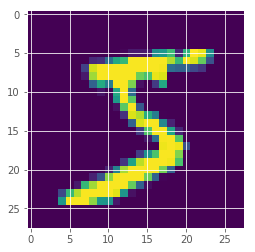

In [0]:
plt.imshow(train_images[0])
print(train_labels[0])
print(train_images.shape, train_labels.shape)

A continuación se realiza un acondicionamiento de los datos para utilizarlos como entradas de la red:

In [0]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])
train_images = train_images.astype('float32')
print(train_images.shape)

(60000, 784)


### Normalización de los datos

In [0]:
train_images /= 255

### Centrado en la media

In [0]:
for i in range(train_images[0].shape[0]):
    train_images -= np.mean(train_images[:, i])

### Centrado en la media y normalización con desviación estándar [Opcional]

In [0]:
for i in range(train_images[0].shape[0]):
    train_images -= np.mean(train_images[:, i])
    if (np.isclose(np.std(train_images[:, i]), 0, 1e-4)):
        continue
    train_images = train_images / np.std(train_images[:, i])

In [0]:
# dataset = get_data('train.csv')

dataset = []

for i in range(train_images.shape[0]):
    dataset.append([train_labels[i], train_images[i]])

### División de dataset en train y test

Para la evaluación del aprendizaje de la red se realizó **k-fold cross validation**, con $k=3$, es decir, se deja $1/3$ de los casos de entrenamiento para testing y el experimento se repite $3$ veces.

In [0]:
MAX = int(0.66 * len(dataset))

data_train = dataset[:MAX]
test = dataset[MAX:]

print(len(dataset), len(data_train), len(test))

60000 39600 20400


In [0]:
MAX_K = int(0.66 * len(data_train))

train = data_train[:MAX_K]
validation = data_train[MAX_K:]

print(len(data_train), len(train), len(validation))

39600 26136 13464


### Modelado de la red neuronal

In [0]:
map_kohonen = np.zeros((15, 15)) # Mapa de neuronas
for i in range(map_kohonen.shape[0]):
    for j in range(map_kohonen.shape[1]):
        map_kohonen[i, j] = -1


W = np.zeros((map_kohonen.shape[0], map_kohonen.shape[1], dataset[0][1].shape[0]))

### Inicialización de pesos sinápticos

Se inicializan los pesos sinápticos con números aleatorios pequeños tomados de una distribución Gaussiana con $\mu=0$ y $\sigma=1$:

In [0]:
mu = 0
sigma = 0.2

for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        W[i, j, :] = np.random.normal(mu, sigma, W.shape[2])
        # W[i, j, :] = np.random.uniform(low=-1.0, high=1.0, size=W.shape[2])

## Entrenamiento

In [0]:
t = 0
printProgressBar(t, len(train))
for [_, x] in train:

    g = winner(W, x)

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j, :] = update_w(W[i, j, :], x, [i, j], g, t, lvq=1)

    t += 1
    printProgressBar(t, len(train))

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


## Learning Vector Quantization (LVQ)

### Inicialización del mapa

Muestra representativa de cada clase

In [0]:
sample = []
ctrl = list(range(0, 10))
for [label, x] in train:
    label = int(label)
    if (label in ctrl):
        ctrl.remove(label)
        sample.append([label, x])
    if not ctrl:
        break

#### Asignación de clases

Asignación de clases con muestras del dataset:

In [0]:
def r_aux(a, t_r=1, R_0=1):
    return R_0

In [0]:
for [label, x] in sample:
    g = winner(W, x)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if (vecindad([i, j], g, 0, R=r_aux)):
                map_kohonen[i, j] = int(label)

Asignación de clases a través de algoritmo **K-Means**: [Opcional, no se obtuvieron buenos resultados]

In [0]:
def kmeans(map_kohonen, W, sample):

    # Asignación de centroides iniciales
    means = []
    for [label, x] in sample:
        g = winner(W, x)
        means.append([label, g])

    # Actualización de centroides
    iter = 0
    printProgressBar(iter, 50)
    while (iter < 50):
        minim = inf
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                for [label, mean] in means:
                    aux = d_euclidean(W[mean[0], mean[1], :], W[i, j, :])
                    if (aux < minim):
                        minim = aux
                        map_kohonen[i, j] = label

        sum = np.zeros((10, W.shape[2]))
        dim = np.zeros((10,))
        for i in range(map_kohonen.shape[0]):
            for j in range(map_kohonen.shape[1]):
                label = int(map_kohonen[i, j])
                sum[label, :] += W[i, j, :]
                dim[label] += 1

        means = []
        for [label, mean] in means:
            x = sum[label, :] / dim[label]
            means.append(winner(W, x))

        iter += 1
        printProgressBar(iter, 50)
    
    return map_kohonen

In [0]:
map_kohonen = kmeans(map_kohonen, W, sample)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


### Ajuste fino

In [0]:
t = 0
printProgressBar(t, len(train))

for [label, x] in train:

    label = int(label)
    [i, j] = winner(W, x)

    if (map_kohonen[i, j] == label):
        lvq_c = 1
    else:
        lvq_c = -1

    W[i, j, :] += lvq_c * ritmo_aprendizaje(t, alfa_0=0.4) * (x - W[i, j, :])

    t += 1
    printProgressBar(t, len(train))

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


### Visualización del mapa

In [0]:
def printMap(map_kohonen):
    """Plotear el mapa de kohonen marcando las diferentes clases

    Parameters
    ----------
    map_kohonen : numpy array shape(i, j, k)
        Mapa de kohonen a plotear
    """
    
    colors = ['xb', 'xg', 'xr', 'xc', 'xm', 'xy', 'xk', 'ob', 'og', 'or']
    
    
    for i in range(map_kohonen.shape[0]):
        for j in range(map_kohonen.shape[1]):
            if (map_kohonen[i, j] < 0):
                continue
            digit = int(map_kohonen[i, j])
            plt.plot(i, j, str(colors[digit]), '*', label=str(digit))
    
    # plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
    plt.grid()
    plt.show()

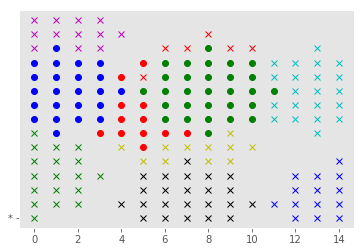

In [0]:
printMap(map_kohonen)

## Test

In [0]:
t = 0
printProgressBar(t, len(validation))

ans = []

for [label, x] in validation:

    label = int(label)
    [i, j] = winner(W, x, map_k=map_kohonen)
    ans.append([i, j])

    if (map_kohonen[i, j] == label):
        t +=1
        printProgressBar(t, len(validation))

In [0]:
print(t*100/len(validation))

90.10695187165776


## Optimización de hiperparámetros de la red

In [0]:
# ANALISIS DEL DATASET

from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])
train_images = train_images.astype('float32')
print(train_images.shape)

# Normalización
# for [label, img] in dataset:
#     img /= 255

train_images /= 255

# Centrado en la media
for i in range(train_images[0].shape[0]):
    train_images -= np.mean(train_images[:, i])
    

dataset = []

for i in range(train_images.shape[0]):
    dataset.append([train_labels[i], train_images[i]])

# DIVISIÓN DE TRAIN Y VALIDATION
        
MAX = int(0.66 * len(dataset))

data_train = dataset[:MAX]
test = dataset[MAX:]

print(len(dataset), len(data_train), len(test))

MAX_K = int(0.66 * len(data_train))

train = data_train[:MAX_K]
validation = data_train[MAX_K:]

print(len(data_train), len(train), len(validation))

performance = []


for prop in np.arange(0.1, 0.9, 0.1):
    
    # INICIALIZACIÓN DE LA RED NEURONAL
    map_kohonen = np.zeros((15, 15)) # Mapa de neuronas
    for i in range(map_kohonen.shape[0]):
        for j in range(map_kohonen.shape[1]):
            map_kohonen[i, j] = -1


    W = np.zeros((map_kohonen.shape[0], map_kohonen.shape[1], dataset[0][1].shape[0]))

    mu = 0
    sigma = 0.2

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j, :] = np.random.normal(mu, sigma, W.shape[2])
            # W[i, j, :] = np.random.uniform(low=-1.0, high=1.0, size=W.shape[2])

    # ENTRENAMIENTO
    t = 0
    printProgressBar(t, len(train))
    for [_, x] in train:

        g = winner(W, x)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i, j, :] = update_w(W[i, j, :], x, [i, j], g, t, lvq=1, dim_data=int(prop*len(train)))

        t += 1
        printProgressBar(t, len(train))

    # LVQ
    # Extracción de muestras
    sample = []
    ctrl = list(range(0, 10))
    for [label, x] in train:
        label = int(label)
        if (label in ctrl):
            ctrl.remove(label)
            sample.append([label, x])
        if not ctrl:
            break
    
    # vecindad(i, g, t, R=radio_vecindad, r=3)
    for [label, x] in sample:
        g = winner(W, x)
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                if (vecindad([i, j], g, 0, R=r_aux)):
                    map_kohonen[i, j] = int(label)

    # Ajuste fino
    t = 0
    printProgressBar(t, len(train))

    for [label, x] in train:

        label = int(label)
        [i, j] = winner(W, x)

        if (map_kohonen[i, j] == label):
            lvq_c = 1
        else:
            lvq_c = -1

        W[i, j, :] += lvq_c * ritmo_aprendizaje(t, alfa_0=alfa) * (x - W[i, j, :])

        t += 1
        printProgressBar(t, len(train))

    # printMap(map_kohonen)

    # VALIDATION
    t = 0
    printProgressBar(t, len(validation))

    ans = []

    for [label, x] in validation:

        label = int(label)
        [i, j] = winner(W, x, map_k=map_kohonen)
        ans.append([i, j])

        if (map_kohonen[i, j] == label):
            t +=1
            printProgressBar(t, len(validation))

    performance.append(t*100/len(validation))

(60000, 784)
60000 39600 20400
39600 26136 13464
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |█████████████████████████████████████████████████████

In [0]:
plt.style.use('ggplot')

### Optimización de $\alpha_0$ en entrenamiento

Text(0, 0.5, 'Validation')

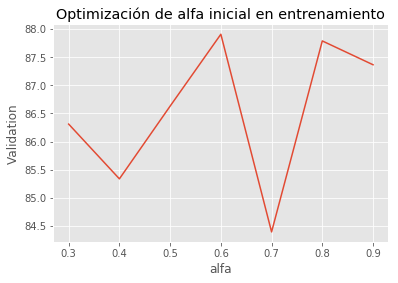

In [0]:
alfa = np.arange(0.3, 0.9, 0.1)
plt.plot(alfa, performance)

plt.title("Optimización de alfa inicial en entrenamiento")
plt.xlabel("alfa")
plt.ylabel("Validation")

### Optimización de R inicial en entranamiento

Text(0, 0.5, 'Validation')

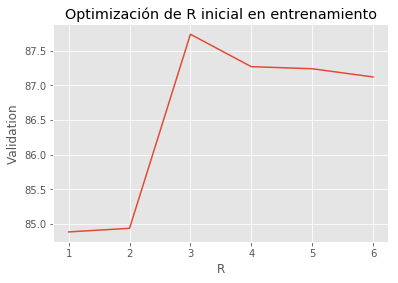

In [0]:
R = np.arange(1, 7, 1)
plt.plot(R, performance)

plt.title("Optimización de R inicial en entrenamiento")
plt.xlabel("R")
plt.ylabel("Validation")

### Optimización de R en inicialización del mapa de Kohonen para algoritmo LVQ

Text(0, 0.5, 'Validation')

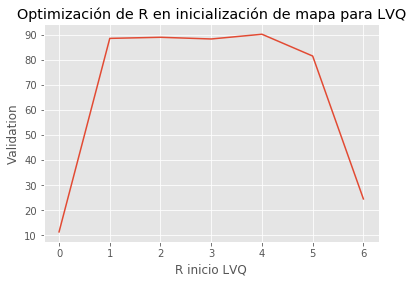

In [0]:
R_init = np.arange(0, 7, 1)
plt.plot(R_init, performance)

plt.title("Optimización de R en inicialización de mapa para LVQ")
plt.xlabel("R inicio LVQ")
plt.ylabel("Validation")

### Optimización de $\alpha_0$ para ritmo de aprendizaje de algoritmo LVQ

Text(0, 0.5, 'Validation')

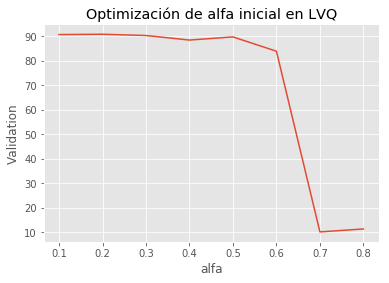

In [0]:
alfa_lvq = np.arange(0.1, 0.9, 0.1)
plt.plot(alfa_lvq, performance)

plt.title("Optimización de alfa inicial en LVQ")
plt.xlabel("alfa")
plt.ylabel("Validation")

Text(0, 0.5, 'Validation')

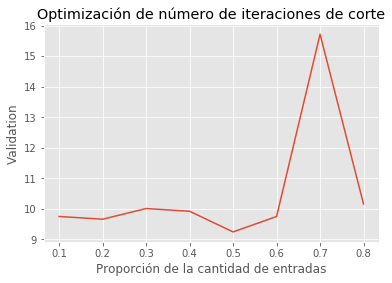

In [0]:
prop_data = np.arange(0.1, 0.9, 0.1)
plt.plot(alfa_lvq, performance)

plt.title("Optimización de número de iteraciones de corte")
plt.xlabel("Proporción de la cantidad de entradas")
plt.ylabel("Validation")

## Validación

In [0]:
def validate_map(train, validation):
    # INICIALIZACIÓN DE LA RED NEURONAL
    map_kohonen = np.zeros((15, 15)) # Mapa de neuronas
    for i in range(map_kohonen.shape[0]):
        for j in range(map_kohonen.shape[1]):
            map_kohonen[i, j] = -1


    W = np.zeros((map_kohonen.shape[0], map_kohonen.shape[1], dataset[0][1].shape[0]))

    mu = 0
    sigma = 0.2

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j, :] = np.random.normal(mu, sigma, W.shape[2])
            # W[i, j, :] = np.random.uniform(low=-1.0, high=1.0, size=W.shape[2])

    # ENTRENAMIENTO
    t = 0
    printProgressBar(t, len(train))
    for [_, x] in train:

        g = winner(W, x)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i, j, :] = update_w(W[i, j, :], x, [i, j], g, t, lvq=1)

        t += 1
        printProgressBar(t, len(train))

    # LVQ
    # Extracción de muestras
    sample = []
    ctrl = list(range(0, 10))
    for [label, x] in train:
        label = int(label)
        if (label in ctrl):
            ctrl.remove(label)
            sample.append([label, x])
        if not ctrl:
            break
    
    # vecindad(i, g, t, R=radio_vecindad, r=3)
    for [label, x] in sample:
        g = winner(W, x)
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                if (vecindad([i, j], g, 0, R=r_aux)):
                    map_kohonen[i, j] = int(label)

    # Ajuste fino
    t = 0
    printProgressBar(t, len(train))

    for [label, x] in train:

        label = int(label)
        [i, j] = winner(W, x)

        if (map_kohonen[i, j] == label):
            lvq_c = 1
        else:
            lvq_c = -1

        W[i, j, :] += lvq_c * ritmo_aprendizaje(t, alfa_0=0.4) * (x - W[i, j, :])

        t += 1
        printProgressBar(t, len(train))

    # printMap(map_kohonen)

    # VALIDATION
    t = 0
    printProgressBar(t, len(validation))

    ans = []

    for [label, x] in validation:

        label = int(label)
        [i, j] = winner(W, x, map_k=map_kohonen)
        ans.append([i, j])

        if (map_kohonen[i, j] == label):
            t +=1
            printProgressBar(t, len(validation))

    return t*100/len(validation)

In [0]:
# ANALISIS DEL DATASET

from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])
train_images = train_images.astype('float32')
print(train_images.shape)

# Normalización
# for [label, img] in dataset:
#     img /= 255

train_images /= 255

# Centrado en la media
for i in range(train_images[0].shape[0]):
    train_images -= np.mean(train_images[:, i])
    

dataset = []

for i in range(train_images.shape[0]):
    dataset.append([train_labels[i], train_images[i]])

# DIVISIÓN DE TRAIN Y VALIDATION
        
MAX = int(0.66 * len(dataset))

data_train = dataset[:MAX]
test = dataset[MAX:]

print(len(dataset), len(data_train), len(test))


# K-FOLD VALIDATION
PIVOT_K = int(0.33 * len(data_train))

train = data_train[:2*PIVOT_K]
validation = data_train[2*PIVOT_K:]

print(len(data_train), len(train), len(validation))

k1 = validate_map(train, validation)

train = data_train[PIVOT_K:]
validation = data_train[:PIVOT_K]

print(len(data_train), len(train), len(validation))

k2 = validate_map(train, validation)

train = data_train[:PIVOT_K] + data_train[2*PIVOT_K:]
validation = data_train[PIVOT_K:2*PIVOT_K:]

print(len(data_train), len(train), len(validation))

k3 = validate_map(train, validation)

(60000, 784)
60000 39600 20400
39600 26136 13464
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
39600 26532 13068
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
39600 26532 13068
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [0]:
print(k1, k2, k3)

87.47771836007131 84.97857361493725 89.13376186103459


## Resultados finales en test

In [0]:

from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])
train_images = train_images.astype('float32')
print(train_images.shape)

# Normalización
# for [label, img] in dataset:
#     img /= 255

train_images /= 255

# Centrado en la media
for i in range(train_images[0].shape[0]):
    train_images -= np.mean(train_images[:, i])
    

dataset = []

for i in range(train_images.shape[0]):
    dataset.append([train_labels[i], train_images[i]])

# DIVISIÓN DE TRAIN Y VALIDATION
        
MAX = int(0.66 * len(dataset))

data_train = dataset[:MAX]
test = dataset[MAX:]

final = validate_map(data_train, test)

(60000, 784)
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [0]:
print(final)

91.07352941176471
